In [1]:
import tftables
import tensorflow as tf
import numpy as np

In [2]:
def input_transform(tbl_batch):
    data = tbl_batch['spectrum']
    metals = tbl_batch['MH_ratio']

    data_float = tf.to_float(data)
    metals_float = tf.to_float(metals)

    data_max = tf.reduce_max(data_float, axis=1)
    normalized_data = tf.divide(data_float,
                                tf.expand_dims(data_max, axis=1))
    
    return normalized_data, metals_float

In [3]:
def create_layer(n_in, n_out, index):
    weight = tf.get_variable('weights-{}'.format(index),
                              shape=(n_in, n_out),
                              dtype=tf.float32,
                              initializer=tf.orthogonal_initializer)
    bias = tf.get_variable('bias-{}'.format(index),
                           shape=(n_out),
                           dtype=tf.float32,
                           initializer=tf.zeros_initializer)
    return weight, bias

In [ ]:
NUM_ITERATIONS = 1000
BATCH_SIZE = 50
NUM_FEATURES = 40
SPECTRA_FEATURES = 1569128

LEARNING_RATE = 0.001

PRINT_FREQ = 10

tf.reset_default_graph()
with tf.device('/cpu:0'):
    loader = tftables.load_dataset(filename='data/sample_8k.h5',
                                   dataset_path='/spectra',
                                   input_transform=input_transform,
                                   batch_size=BATCH_SIZE,
                                   cyclic=True,
                                   ordered=True)
    data_batch, metals_batch = loader.dequeue()
    
    layer_sizes = [NUM_FEATURES, 50, 50, 75, 75, 100, 100, SPECTRA_FEATURES]
    
    weights = []
    biases = []
    layers = [data_batch]
    for i in reversed(range(1, len(layer_sizes))):
        weight, bias = create_layer(layer_sizes[i], layer_sizes[i-1], -i)
        weights.append(weight)
        biases.append(bias)
        layers.append(tf.nn.relu(tf.matmul(layers[-1], weights[-1]) + bias[-1]))
   
    for i in range(len(layer_sizes)-1):
        weight, bias = create_layer(layer_sizes[i], layer_sizes[i+1], i)
        weights.append(weight)
        biases.append(bias)
        layers.append(tf.nn.relu(tf.matmul(layers[-1], weights[-1]) + bias[-1]))
    
    squared_error = tf.reduce_sum(tf.abs(tf.subtract(layers[0], layers[-1])))
    global_step = tf.Variable(0, trainable=False)
    optimize = tf.train.AdamOptimizer(LEARNING_RATE).minimize(squared_error, global_step=global_step)
    
    with tf.Session() as sess:
        with loader.begin(sess):
            sess.run(tf.global_variables_initializer())
            for i in range(NUM_ITERATIONS):
                _, se, ws, bs, ls = sess.run([optimize, squared_error, weights, biases, layers])
                if i % PRINT_FREQ == 0:
                    print(i, '\t', se)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
0 	 29067348.0
10 	 11856152.0
20 	 8999619.0
30 	 7029426.5
40 	 5400807.5
50 	 6102469.0
60 	 6064240.5
70 	 4961897.5
80 	 4744751.5
90 	 4620625.0
100 	 6045267.5
110 	 5130478.5
120 	 3705141.8
130 	 3535032.5
140 	 3719153.8
150 	 3824759.5


In [1]:
from datetime import datetime
import tables
import matplotlib.pyplot as plt

In [ ]:
# save info
outfile_name = 'output/output-{}'.format(datetime.now().strftime('%y%m%d-%H%M%S'))
metadata = np.array((NUM_ITERATIONS, BATCH_SIZE, NUM_FEATURES, LEARNING_RATE, layer_sizes, 'relu'))
np.savez_compressed(outfile_name, metadata=metadata, ws=ws, bs=bs)
print('Saved {}.npz with metadata: {}'.format(outfile_name, metadata))

In [4]:
file = np.load('output/output-190905-161751.npz')
ws = file['ws']
bs = file['bs']

In [5]:
h5file = tables.open_file('data/sample_8k.h5', 'r')
h5node = h5file.get_node('/spectra')

spectra = h5node[:1000]['spectrum']
normalized_spectra = spectra / np.max(spectra, axis=1)[:, np.newaxis]

h5file.close()

In [6]:
def recreate_spectra(spectrum, ws, bs):
    s = np.copy(spectrum)
    for i in range(len(ws)):
        s = np.clip(ws[i].T @ s + bs[i], 0, None)
        print(i, s.shape)
    return s

In [10]:
INDEX = 5
recreation = recreate_spectra(normalized_spectra[INDEX], ws, bs)

0 (100,)
1 (100,)
2 (75,)
3 (75,)
4 (50,)
5 (50,)
6 (40,)
7 (50,)
8 (50,)
9 (75,)
10 (75,)
11 (100,)
12 (100,)
13 (1569128,)


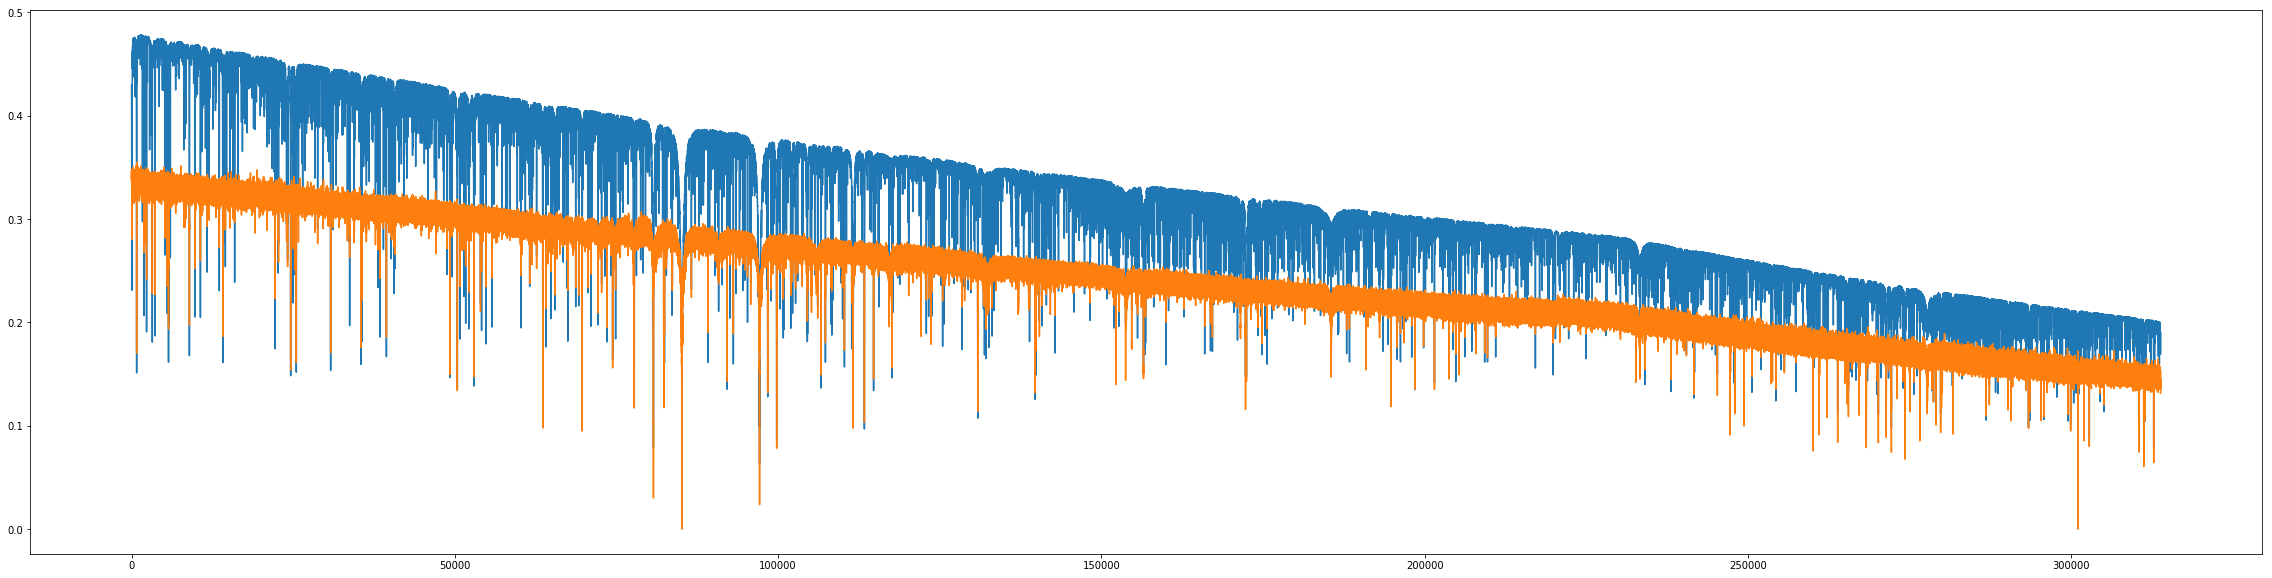

In [11]:
width = len(normalized_spectra[0])
left, right = int(0.4 * width), int(.6 * width)
plt.figure(figsize=(40,10))
plt.plot(normalized_spectra[INDEX][left:right])
plt.plot(recreation[left:right])

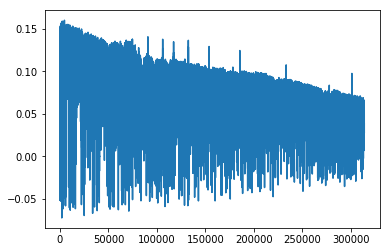

In [12]:
plt.plot(normalized_spectra[INDEX][left:right] - recreation[left:right])